# <center><b><font color='blue'>Bitcoin Price Prediction</font></b></center>

TABLA DE CONTENIDO

...

<a name="1"></a>
## 1. Objetivos

Aprender acerca de las series temporales.

<a name="2"></a>
## 2. Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime
import random

<a name="3"></a>
## 3. Helper Functions

In [145]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)


    
# se implementa MASE pues no existe en TF
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season
    
    
    
# make predictions
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions



# Evaluaci[on  de predicciones

# Create a function to take in model predictions and truth values and return evaluation metrics
# sirve para horizonte largo 1
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds_general(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}



# predicciones de un ensamble
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))





# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    
    Recine arreglos de numpy
    Devuelve arreglos de numpy
    
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# create windowed dataset
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    # drop nan values
    dataset_windowed.dropna(inplace=True)
    
    # convert to float32
    dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)

    # return
    return dataset_windowed



# combino el ore-procesamiento en uan funcion
def pre_process_data(dataset,window_size):
    # create windowed dataset
    dataset_windowed = create_windowed_dataset(dataset,window_size)
    # Create X (windows) and y (horizons) features
    X = dataset_windowed.drop("Price", axis=1)
    y = dataset_windowed["Price"]
    # train/test split
    X_train, X_test, y_train, y_test = make_train_test_splits(X.values, y.values)
    # return
    return X_train, X_test, y_train, y_test
    



# para horizontes mayores

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]


# Create function to view NumPy arrays as windows
def make_windows_general(x, window_size, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels


# plot
def plot_time_series(len_test,indices,y_test,model_preds):
    # le paso los indices del dataframe (las fechas)
    # debo tomar los del conjunto de test, ultimos len(X_test) de los datos de entrenamiento X
    # es de X pues X_test no tiene el indice de las fechas
    plt.figure(figsize=(12, 8))
    plt.plot(indices.values[-len_test:],y_test,marker='.', linestyle='',color='red',label='tets data')
    plt.plot(indices.values[-len_test:],model_preds,label='preds')
    # Agregar leyenda
    plt.legend()



<a name="4"></a>
## 4. Carga y pre-procesamiento de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [11]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [12]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [14]:
df.shape

(2787, 5)

In [15]:
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


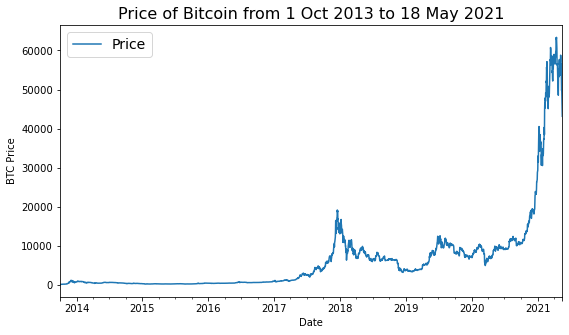

In [16]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

Por ello, en lugar de usar train/test/split de ScikitLearn, usaremos slicing.

In [17]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [18]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

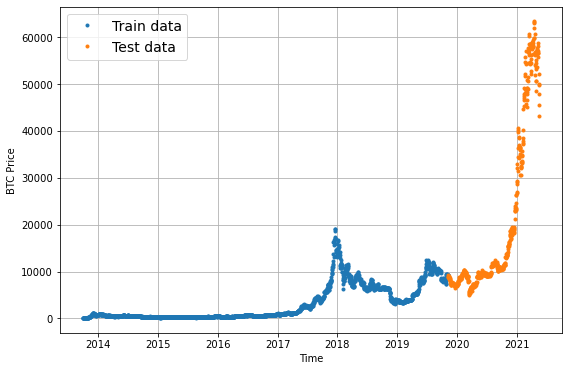

In [19]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

<a name="6"></a>
## 5. Modelos

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Conv1D
* 4	LSTM

In [114]:
# Configurar la semilla aleatoria para TensorFlow
seed_value = 42
tf.random.set_seed(seed_value)

### 5.1. Naive Forecast

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [20]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

----------------------- GRAFICAS!!!!!!!!!!

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [115]:
# horizon and window size
HORIZON = 1
WINDOW_SIZE = 7

# train/test data
X_train, X_test, y_train, y_test = pre_process_data(bitcoin_prices,WINDOW_SIZE)

In [116]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [117]:
# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test))
            #callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [25]:
# Evaluate model on test data
model_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 659.4442 - mae: 659.4442 - mse: 1377514.0000


[659.4442138671875, 659.4442138671875, 1377514.0]

In [26]:
model_1.predict

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000001F7891F0CD0>>

In [27]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, X_test) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9018.521, 8920.93 , 9184.515, 8936.524, 8872.671, 8890.865,
        8846.287, 8649.895, 8611.62 , 8672.031], dtype=float32)>)

In [28]:
# Evaluate preds
model_1_results = evaluate_preds_general(y_true=tf.squeeze(y_test),
                                 y_pred=model_1_preds) # ídem con evaluate_preds
model_1_results

{'mae': 659.4443,
 'mse': 1377514.2,
 'rmse': 1173.6755,
 'mape': 3.0752928,
 'mase': 1.158461}

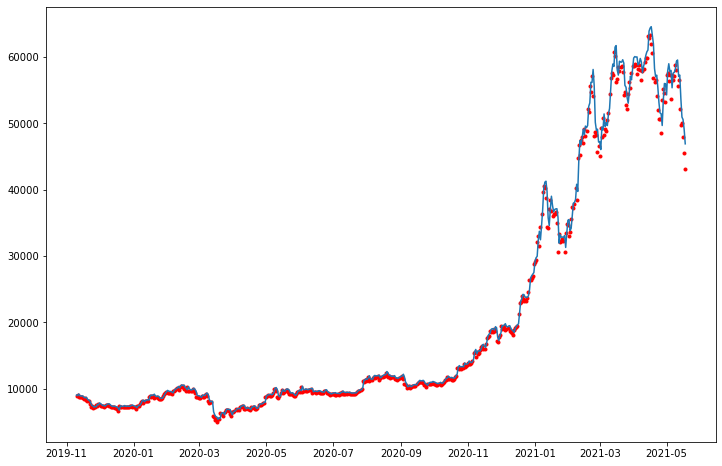

In [92]:
indices = bitcoin_prices.index
indices.values[-10:] # ultimos elementos

plot_time_series(len(X_test),indices,y_test,model_1_preds)

### Model 2: Dense (window = 30, horizon = 1)

In [94]:
# horizon and window size
HORIZON = 1
WINDOW_SIZE = 30

# train/test data
X_train, X_test, y_train, y_test = pre_process_data(bitcoin_prices,WINDOW_SIZE)

In [95]:
# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test))


In [96]:
# Evaluate model on test data
model_2.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 1619.2520


1619.251953125

In [97]:
# Make predictions using model_1 on the test dataset and view results
model_2_preds = make_preds(model_2, X_test) 
len(model_2_preds), model_2_preds[:10]

18/18 [==============================] - 0s 3ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8179.64  , 8131.635 , 8136.471 , 7895.2783, 7687.164 , 7655.4175,
        7402.0093, 7420.371 , 7542.9595, 7077.991 ], dtype=float32)>)

In [98]:
# Evaluate preds
model_2_results = evaluate_preds_general(y_true=tf.squeeze(y_test),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1619.2521,
 'mse': 5434831.0,
 'rmse': 2331.2725,
 'mape': 8.14812,
 'mase': 2.8304687}

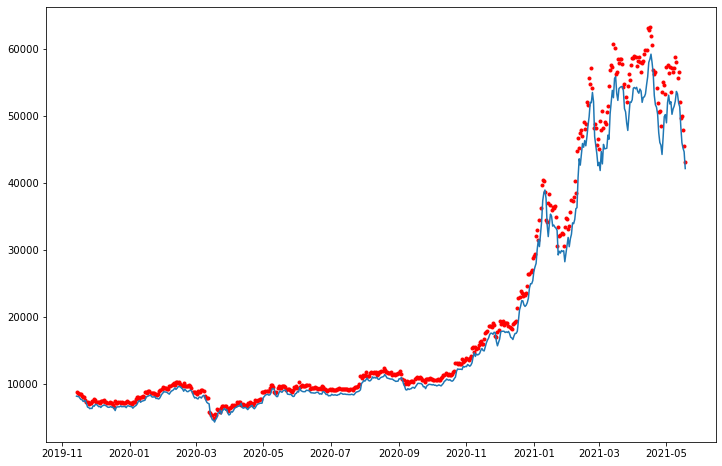

In [99]:
indices = bitcoin_prices.index
indices.values[-10:] # ultimos elementos

plot_time_series(len(X_test),indices,y_test,model_2_preds)

### Model 3 : Conv1D

1. Crear ventanas

2. Train/test split

In [121]:
HORIZON = 1
WINDOW_SIZE = 7

# train/test data
X_train, X_test, y_train, y_test = pre_process_data(bitcoin_prices,WINDOW_SIZE)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

En el contexto de un problema de series temporales con un horizonte (horizon) de 1 y un tamaño de ventana (window_size) de 7, la forma del tensor de entrada (input_shape) sería crucial para determinar el tamaño de input_dim. La forma general del tensor sería (batch_size, window_size, input_dim).

Dado que window_size es 7, el modelo consideraría secuencias de 7 pasos temporales como entrada en cada lote. Sin embargo, el horizonte de predicción (horizon) es 1, lo que significa que el modelo está diseñado para predecir el siguiente paso temporal en cada secuencia.

Por lo tanto, el tamaño de input_dim debe ser el número de características o variables en cada paso temporal. Si tus secuencias tienen una única característica en cada paso de tiempo (por ejemplo, univariadas), entonces input_dim sería 1. Si tienes múltiples características en cada paso de tiempo (por ejemplo, series temporales multivariadas), entonces input_dim sería el número total de características.

Entonces, en resumen, para un problema de series temporales con un horizonte de 1 y una ventana de 7, y si tus datos tienen una sola característica en cada paso de tiempo, input_dim debería ser 1. Si tienes múltiples características en cada paso de tiempo, input_dim sería el número total de características.

In [123]:
def build_model_3(horizon,name):
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.Dense(horizon)
    ],name=name)
    return model
    
    
model_3 = build_model_3(1,"model_3_conv1D")

In [124]:
# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(X_train,
            y_train,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(X_test, y_test))
            #callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [125]:
# Evaluate model on test data
model_3.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 17660.3594


17660.359375

In [143]:
# Make predictions using model_1 on the test dataset and view results
model_3_preds = make_preds(model_3, X_test) 
len(model_3_preds), model_3_preds[:10]


y_test[:10], model_3_preds[:10]

18/18 [==============================] - 0s 2ms/step


(array([8798.042 , 9081.187 , 8711.534 , 8760.893 , 8749.5205, 8656.971 ,
        8500.644 , 8469.261 , 8537.34  , 8205.807 ], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1099.7885, 1045.6232, 1051.4542, 1072.4384, 1051.6952, 1044.7711,
        1069.7057, 1020.6836, 1022.8924, 1019.4231], dtype=float32)>)

In [138]:
# Evaluate preds
model_3_results = evaluate_preds_general(y_true=tf.squeeze(y_test),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 17660.361,
 'mse': 549434050.0,
 'rmse': 23440.01,
 'mape': 87.84382,
 'mase': 31.024363}

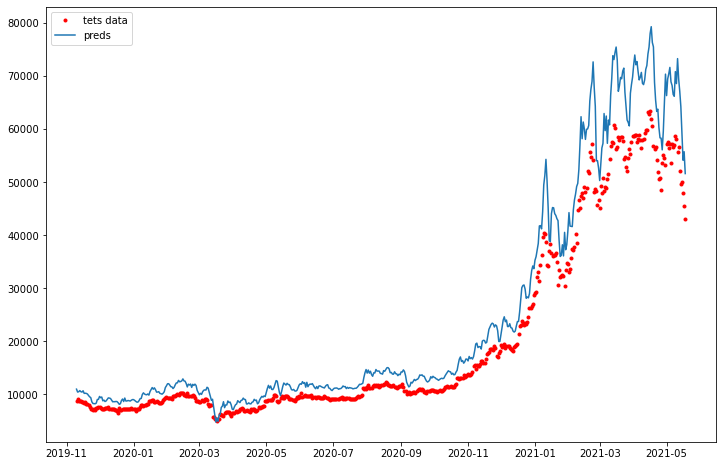

In [146]:
indices = bitcoin_prices.index
indices.values[-10:] # ultimos elementos


plot_time_series(len(X_test),indices,y_test,model_3_preds*10) # ???????

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.



In [107]:
HORIZON = 1
WINDOW_SIZE = 7

# train/test data
X_train, X_test, y_train, y_test = pre_process_data(bitcoin_prices,WINDOW_SIZE)

In [108]:
def build_model_4(window_size,name):
    # Let's build an LSTM model with the Functional API
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    # x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name=name)
    return model


model_4 = build_model_4(WINDOW_SIZE,"model_5_LSTM")
    
    
# Compile
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test))
            #callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [109]:
# Evaluate model on test data
model_4.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 593.7762


593.7762451171875

In [110]:
# Make predictions using model_1 on the test dataset and view results
model_4_preds = make_preds(model_4, X_test) 
len(model_4_preds), model_4_preds[:10]

18/18 [==============================] - 0s 4ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8907.897, 8779.582, 8921.285, 8773.157, 8728.183, 8688.395,
        8654.229, 8543.888, 8423.562, 8479.886], dtype=float32)>)

In [111]:
# Evaluate preds
model_4_results = evaluate_preds_general(y_true=tf.squeeze(y_test),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 593.7763,
 'mse': 1245382.5,
 'rmse': 1115.967,
 'mape': 2.668414,
 'mase': 1.0431005}

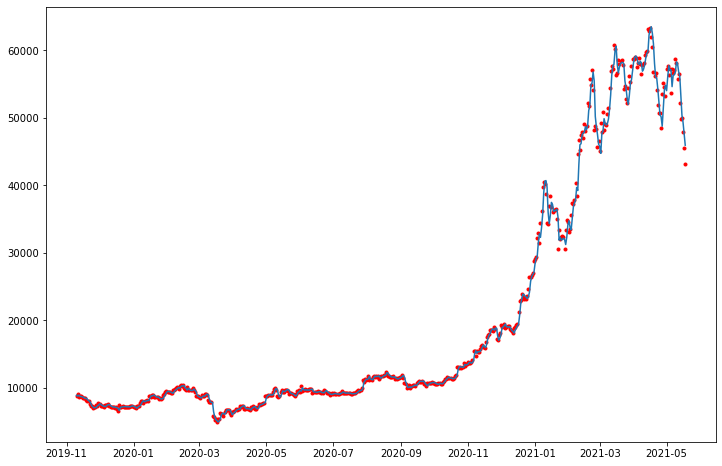

In [112]:
indices = bitcoin_prices.index
indices.values[-10:] # ultimos elementos

plot_time_series(len(X_test),indices,y_test,model_4_preds)

### Ensembling learning

In [61]:
HORIZON = 1
WINDOW_SIZE = 7

# train/test data
X_train, X_test, y_train, y_test = pre_process_data(bitcoin_prices,WINDOW_SIZE)

In [62]:
# usar tf.data por performance

# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [63]:

"""
los modelos siguientes son diferentes debido a a la aleatoriedad,
por ejemplo al tener las capas inicializacion aleatoria
"""

def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=5,#3
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=150,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models 
  


In [64]:
# Example usage:
# train_dataset y test_dataset deben ser definidos antes de llamar a get_ensemble_models
# HORIZON también debe ser definido previamente
ensemble_models = get_ensemble_models(train_data=train_dataset, test_data=test_dataset, num_iter=5, num_epochs=200)

Optimizing model by reducing: mae for 200 epochs, model number: 0
Optimizing model by reducing: mse for 200 epochs, model number: 0
Optimizing model by reducing: mape for 200 epochs, model number: 0
Optimizing model by reducing: mae for 200 epochs, model number: 1
Optimizing model by reducing: mse for 200 epochs, model number: 1
Optimizing model by reducing: mape for 200 epochs, model number: 1

Epoch 149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 200 epochs, model number: 2
Optimizing model by reducing: mse for 200 epochs, model number: 2
Optimizing model by reducing: mape for 200 epochs, model number: 2
Optimizing model by reducing: mae for 200 epochs, model number: 3
Optimizing model by reducing: mse for 200 epochs, model number: 3
Optimizing model by reducing: mape for 200 epochs, model number: 3

Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 200 ep

In [65]:
ensemble_models

In [69]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 127ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 7750.936 ,  7245.714 ,  7524.292 , ..., 42561.992 , 44513.227 ,
        39781.152 ],
       [ 8807.164 ,  8787.912 ,  9111.559 , ..., 49894.613 , 48366.418 ,
        45265.797 ],
       [ 9030.105 ,  9038.463 ,  9305.44  , ..., 51555.566 , 50029.676 ,
        46790.227 ],
       ...,
       [ 8784.141 ,  8898.72  ,  8919.604 , ..., 50477.816 , 48207.66  ,
        48692.83  ],
       [ 8823.628 ,  8725.5205,  8992.399 , ..., 49514.285 , 48368.97  ,
        45328.406 ],
       [ 8817.965 ,  8819.556 ,  9099.74  , ..., 50120.77  , 47897.527 ,
        46178.285 ]], dtype=float32)>

In [70]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 7750.936 ,  7245.714 ,  7524.292 , ..., 42561.992 , 44513.227 ,
        39781.152 ],
       [ 8807.164 ,  8787.912 ,  9111.559 , ..., 49894.613 , 48366.418 ,
        45265.797 ],
       [ 9030.105 ,  9038.463 ,  9305.44  , ..., 51555.566 , 50029.676 ,
        46790.227 ],
       ...,
       [ 8784.141 ,  8898.72  ,  8919.604 , ..., 50477.816 , 48207.66  ,
        48692.83  ],
       [ 8823.628 ,  8725.5205,  8992.399 , ..., 49514.285 , 48368.97  ,
        45328.406 ],
       [ 8817.965 ,  8819.556 ,  9099.74  , ..., 50120.77  , 47897.527 ,
        46178.285 ]], dtype=float32)>

In [73]:
ensemble_preds.shape

TensorShape([15, 556])

vemos que nos da una prediccion por cada uno de los 15 modelos, debemos combinarlas!

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [71]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8777.48 , 8727.197, 8972.549, 8667.987, 8683.498, 8693.142,
       8591.376, 8430.565, 8414.318, 8448.97 ], dtype=float32)>

In [72]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds_general(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 596.176,
 'mse': 1217345.6,
 'rmse': 1103.3339,
 'mape': 2.7096913,
 'mase': 1.0473162}

## Comparando modelos

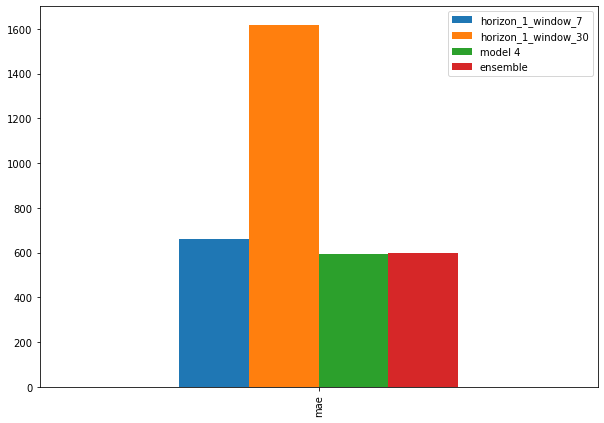

In [113]:
pd.DataFrame({#"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              #"model 4": model_4_results["mae"], 
    "model 4": model_4_results["mae"],
    "ensemble": ensemble_results["mae"]},
    index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Larger horizonts

Ahora buscaremos predecir una mayor cantidad de dias en el futuro

In [78]:
HORIZON = 7
WINDOW_SIZE = 30

In [80]:
full_windows, full_labels = make_windows_general(prices, window_size=WINDOW_SIZE, horizon=HORIZON) #prices = bitcoin_prices["Price"].to_numpy()
len(full_windows), len(full_labels)

(2751, 2751)

In [81]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795
 123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199
 133.20333 142.76333 137.92333 142.95166 152.55183 160.33883 164.31499
 177.63333 188.29716 200.70166 180.355   175.03166 177.6965  187.15983
 192.75666 197.4    ] -> Label: [196.02499 198.04883 198.93233 200.543   210.3075  225.02    248.25333]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033
 124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333
 142.76333 137.92333 142.95166 152.55183 160.33883 164.31499 177.63333
 188.29716 200.70166 180.355   175.03166 177.6965  187.15983 192.75666
 197.4     196.02499] -> Label: [198.04883 198.93233 200.543   210.3075  225.02    248.25333 262.32666]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049
 125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333
 137.92333 142.95166 152.55183 160.33883 164.31499 177.63333 188

In [82]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [83]:
# Create model (same as model_1 except with different data input and output sizes)
model = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model")

# Compile
model.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels))
            #callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [84]:
# Evaluate the model on the test data
model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1262.0603


1262.060302734375

In [85]:
# Make predictions with model_3
model_preds = make_preds(model,
                           input_data=test_windows)
model_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9458.127 , 9450.753 , 9435.118 , 9429.823 , 9591.992 , 9385.419 ,
        9644.058 ],
       [9127.963 , 9264.853 , 8878.32  , 9229.912 , 9324.211 , 9012.077 ,
        9392.825 ],
       [8980.3125, 9097.095 , 8943.549 , 9062.408 , 8989.967 , 8911.9375,
        9169.753 ],
       [9222.856 , 9226.099 , 9422.615 , 9282.87  , 9047.25  , 9276.195 ,
        9226.299 ],
       [9246.718 , 9235.759 , 9325.315 , 9077.8955, 9052.502 , 9280.218 ,
        9028.971 ]], dtype=float32)>

In [86]:
# Evaluate model results (these are going multi-dimensional because we're trying to predict more than 
#one timestep at a time)
model_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_preds)
model_results

{'mae': array([  691.8265  ,   424.4816  ,   346.6801  ,   616.86035 ,
          623.84906 ,   586.80725 ,   551.9467  ,   447.45557 ,
          521.0913  ,   608.561   ,   833.3068  ,   883.0492  ,
          951.34045 ,   918.3192  ,   692.5011  ,   300.22818 ,
          235.94426 ,   291.40793 ,   254.94678 ,   178.3238  ,
          143.59842 ,   201.55266 ,   439.0452  ,   395.16742 ,
          301.1326  ,   221.73744 ,   124.902695,    96.71275 ,
           71.24379 ,   201.40074 ,   300.99023 ,   421.9156  ,
          437.17773 ,   407.85553 ,   332.98373 ,   350.6186  ,
          332.13763 ,   283.58643 ,   219.63045 ,   215.74832 ,
          450.5157  ,   136.62068 ,    99.70375 ,   120.77302 ,
          198.44656 ,   161.76123 ,   156.38086 ,   138.77547 ,
           90.53767 ,   112.28467 ,   114.09389 ,   182.95312 ,
          247.52873 ,   266.63657 ,   285.9059  ,   343.8079  ,
          481.2661  ,   456.49365 ,   445.24496 ,   538.9281  ,
          336.40512 ,   203.15486

In [90]:
# Get model results aggregated to single values
model_results = evaluate_preds_general(y_true=tf.squeeze(test_labels),
                                 y_pred=model_preds)
model_results

{'mae': 1262.0604,
 'mse': 5492547.5,
 'rmse': 1442.8613,
 'mape': 5.721401,
 'mase': 2.2457657}

## ANEXO

EVALUANDO SERIES TEMPORALES

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

#### <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> Antes usamos train/dev/test, ahora usaremos ventanas

Creamos ventanas para convertir nuestros datos en un problema de aprendizaje supervisado


```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]


```

Usaremos https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html para crear las venatas con Pandas.

In [ ]:
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # podr[ia devolverlo como arreglo de numpy (con df.values o to_numpy())
    
    return dataset_windowed


# drop nan values

# Create X (windows) and y (horizons) features
X = bitcoin_windowed_m4.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_windowed_m4.dropna()["Price"].astype(np.float32)


bitcoin_windowed_m4 = create_windowed_dataset(bitcoin_prices,WINDOW_SIZE)

In [ ]:
# expand dims layer

expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`
x = tf.constant(train_windows[0]) #.values[0]) # convierto df a numpy<   train_windows.values[0]

# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

In [ ]:
import pandas as pd
import numpy as np


df = bitcoin_prices


def create_windowed_dataset(dataset, window_size, horizon):
    """
    dataset: DataFrame con una columna "Price"
    window_size: tamaño de la ventana
    horizon: horizonte de predicción
    """
    # Hacer una copia del DataFrame
    dataset_windowed = dataset.copy()

    # Añadir columnas para la ventana
    for i in range(window_size):
        # Shift de los valores para cada paso en WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)

    # Drop de valores NaN
    #dataset_windowed.dropna(inplace=True)

    # Convertir a tipo de datos float32
    dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)

    # Crear columnas para el horizonte de predicción
    #for i in range(1, horizon + 1):
    #    dataset_windowed[f"Price+{window_size + i}"] = dataset_windowed["Price"].shift(periods=-i)

    # Drop de valores NaN después de agregar el horizonte
    #dataset_windowed.dropna(inplace=True)

    return dataset_windowed

# Ejemplo de uso:
# Suponiendo que tienes un DataFrame llamado 'df' con una columna 'Price'
# y quieres una ventana de tamaño 3 y un horizonte de predicción de 2

#windowed_df = create_windowed_dataset(df, window_size=2, horizon=2)
#print(windowed_df.head())


In [ ]:
import pandas as pd
import numpy as np

# Crear un DataFrame simple
data = {
    'Date': pd.date_range(start='2022-01-01', periods=10, freq='D'),
    'Price': [1.0, 1.2, 1.5, 1.8, 2.0, 2.3, 2.6, 2.8, 3.0, 3.2]
}

df = pd.DataFrame(data)

# Mostrar el DataFrame original
print("DataFrame Original:")
print(df)

# Aplicar la función create_windowed_dataset
windowed_df = create_windowed_dataset(df, window_size=2, horizon=1)

# Mostrar el DataFrame con windowing
print("\nDataFrame con Windowing:")
print(windowed_df)


"es como predecir price con price+1 y price+2", para los valores price+1 y price+2 el horizonte es price

### larger horizonts

In [10]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7
